In [0]:
import os
from datetime import datetime
from statsmodels.datasets import co2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fastprogress import progress_bar as pb
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [0]:
pd.plotting.register_matplotlib_converters()

In [0]:
df = co2.load_pandas().data

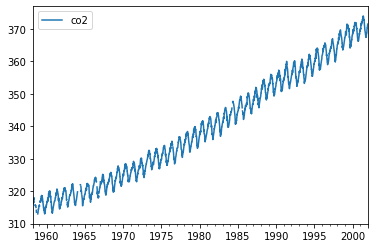

In [4]:
df.plot()

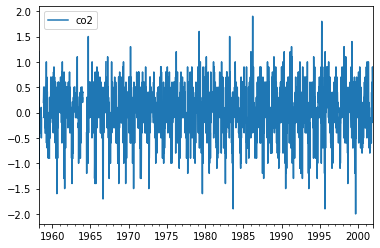

In [5]:
df.diff().plot()

In [6]:
df.isnull().sum()

co2    59
dtype: int64

In [0]:
df.fillna(method='ffill', inplace=True)

In [8]:
df.isnull().sum()

co2    0
dtype: int64

In [0]:
import torch
import torch.nn as nn

In [0]:
class LSTM(nn.Module):

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int
    ):
        super(LSTM, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self._num_layers = num_layers
        self._output_dim = output_dim

        self._lstm = nn.LSTM(
            input_size=self._input_dim,
            hidden_size=self._hidden_dim,
            num_layers=self._num_layers,
            batch_first=True
        )

        self._linear = nn.Linear(
            self._hidden_dim,
            self._output_dim
        )

    def forward(self, x):
        self._lstm.flatten_parameters()
        out, hidden = self._lstm(x)
        return self._linear(out[:, :, :])

In [0]:
class BILSTM(nn.Module):

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int
    ):
        super(BILSTM, self).__init__()
        self._input_dim = input_dim
        self._hidden_dim = hidden_dim
        self._num_layers = num_layers
        self._output_dim = output_dim

        self._lstm = nn.LSTM(
            input_size=self._input_dim,
            hidden_size=self._hidden_dim,
            num_layers=self._num_layers,
            batch_first=True,
            bidirectional=True
        )

        self._linear = nn.Linear(
            self._hidden_dim*2,
            self._output_dim
        )

    def forward(self, x):
        self._lstm.flatten_parameters()
        out, hidden = self._lstm(x)
        return self._linear(out[:, :, :])

In [0]:
lstm = LSTM(
    input_dim=1,
    hidden_dim=32,
    num_layers=2,
    output_dim=1
)

In [0]:
bilstm = BILSTM(
    input_dim=1,
    hidden_dim=32,
    num_layers=2,
    output_dim=1
)

In [0]:
res = lstm(torch.randn(1, 10, 1))

In [261]:
res.shape

torch.Size([1, 10, 1])

In [0]:
res = bilstm(torch.randn(1, 10, 1))

In [263]:
res.shape

torch.Size([1, 10, 1])

In [264]:
df['co2'][:10]

1958-03-29    316.1
1958-04-05    317.3
1958-04-12    317.6
1958-04-19    317.5
1958-04-26    316.4
1958-05-03    316.9
1958-05-10    316.9
1958-05-17    317.5
1958-05-24    317.9
1958-05-31    317.9
Freq: W-SAT, Name: co2, dtype: float64

In [0]:
mms = MinMaxScaler(feature_range=(0.3, 0.7))
ss = StandardScaler()

In [0]:
# co2_timeseries = list(mms.fit_transform(df['co2'].to_numpy().reshape(-1, 1)).flatten())
co2_timeseries = df['co2'].to_numpy().tolist()

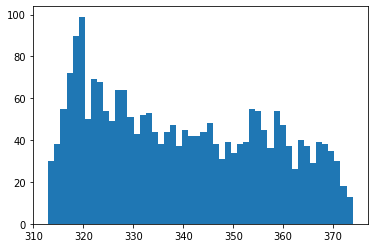

In [267]:
_ = plt.hist(co2_timeseries, bins=50)

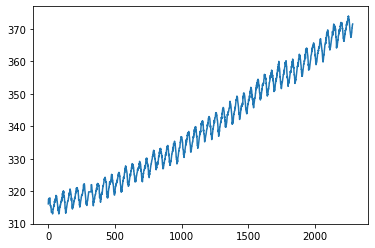

In [268]:
plt.plot(co2_timeseries)

In [269]:
len(co2_timeseries)

2284

In [0]:
train_data = co2_timeseries[:1500]
test_data = co2_timeseries[1500:]

In [0]:
SEQ_LEN = 64
FEAT_DIM = 1

In [0]:
def create_train_dataset(train_data, seq_len):
    xs = []
    ys = []
    mmss = []
    for t in range(len(train_data)-seq_len-1):
        mms = MinMaxScaler(feature_range=(-0.5, 0.5))
        x = mms.fit_transform(np.array(train_data[t:t+SEQ_LEN]).reshape(-1, 1)).flatten()
        y = mms.transform(np.array(train_data[t+1:t+SEQ_LEN+1]).reshape(-1, 1)).flatten()
        xs.append(torch.Tensor(x).view(seq_len, 1))
        ys.append(torch.Tensor(y).view(seq_len, 1))
        mmss.append(mms)
    
    return torch.stack(xs, dim=0), torch.stack(ys, dim=0), mmss

In [0]:
train_dataset_x, train_dataset_y, mmss = create_train_dataset(train_data, SEQ_LEN)

In [274]:
train_dataset_x.shape

torch.Size([1435, 64, 1])

In [0]:
BATCH_SIZE = 64
EPOCHS = 400

In [276]:
lstm.cuda()
bilstm.cuda()

BILSTM(
  (_lstm): LSTM(1, 32, num_layers=2, batch_first=True, bidirectional=True)
  (_linear): Linear(in_features=64, out_features=1, bias=True)
)

In [277]:
mse_loss = nn.MSELoss()
optim_lstm = torch.optim.Adam(
    params=lstm.parameters(),
    lr=0.01,
)
optim_bilstm = torch.optim.Adam(
    params=bilstm.parameters(),
    lr=0.01,
)

loss_history_lstm = []
loss_history_bilstm = []

for n in pb(range(EPOCHS)):
    losses_lstm = []
    losses_bilstm = []
    for t in range(train_dataset_x.size(0)//BATCH_SIZE):

        x = train_dataset_x[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :].to('cuda')
        #next_val = train_data[t+SEQ_LEN]
        y = train_dataset_y[t*BATCH_SIZE:(t+1)*BATCH_SIZE, :, :].to('cuda')

        out_lstm = lstm(x)
        loss_lstm = mse_loss(out_lstm, y)
        # loss_lstm = mse_loss(out_lstm[:, -1, :], y[:, -1, :])
        
        optim_lstm.zero_grad()        
        loss_lstm.backward()
        optim_lstm.step()

        out_bilstm = bilstm(x)
        loss_bilstm = mse_loss(out_bilstm, y)
        # loss_bilstm = mse_loss(out_bilstm[:, -1, :], y[:, -1, :])
        
        optim_bilstm.zero_grad()        
        loss_bilstm.backward()
        optim_bilstm.step()

        losses_lstm.append(loss_lstm.item())
        losses_bilstm.append(loss_bilstm.item())

    loss_history_lstm.append(sum(losses_lstm) / len(losses_lstm))
    loss_history_bilstm.append(sum(losses_bilstm) / len(losses_bilstm))

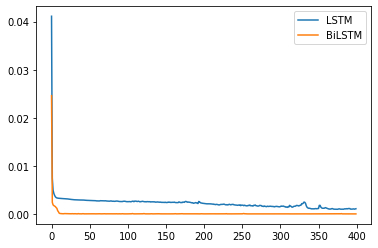

In [278]:
plt.plot(loss_history_lstm, label='LSTM')
plt.plot(loss_history_bilstm, label='BiLSTM')
plt.legend()

In [279]:
lstm.cpu()
bilstm.cpu()

BILSTM(
  (_lstm): LSTM(1, 32, num_layers=2, batch_first=True, bidirectional=True)
  (_linear): Linear(in_features=64, out_features=1, bias=True)
)

In [280]:
input_data_lstm = train_data[-SEQ_LEN:]
input_data_bilstm = train_data[-SEQ_LEN:]
preds_lstm = []
preds_bilstm = []

for i in pb(range(500)):
    mms = MinMaxScaler(feature_range=(-0.5, 0.5))
    input_data_lstm_scaled = mms.fit_transform(np.array(input_data_lstm).reshape(-1, 1)).flatten().tolist()

    out = lstm(torch.Tensor(input_data_lstm_scaled).view(1, SEQ_LEN, FEAT_DIM))
    preds_lstm.append(mms.inverse_transform(out[0, -1, 0].detach().numpy().reshape(-1, 1))[0][0])
    input_data_lstm = input_data_lstm[1:] + [preds_lstm[-1]]

    mms = MinMaxScaler(feature_range=(-0.5, 0.5))
    input_data_bilstm_scaled = mms.fit_transform(np.array(input_data_bilstm).reshape(-1, 1)).flatten().tolist()

    out = bilstm(torch.Tensor(input_data_bilstm_scaled).view(1, SEQ_LEN, FEAT_DIM))
    preds_bilstm.append(mms.inverse_transform(out[0, -1, 0].detach().numpy().reshape(-1, 1))[0][0])
    input_data_bilstm = input_data_bilstm[1:] + [preds_bilstm[-1]]

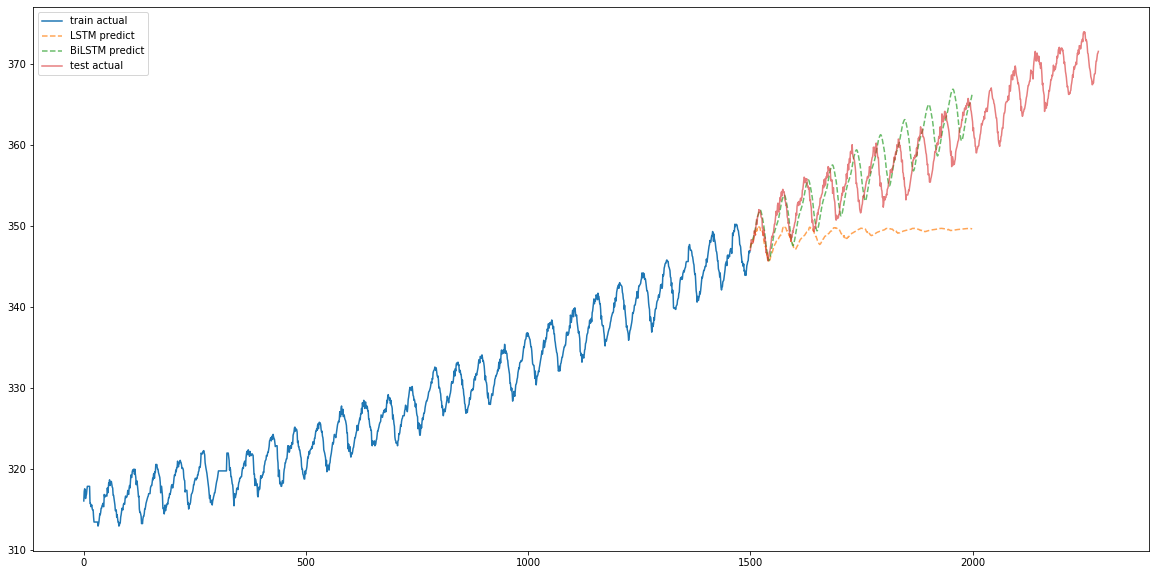

In [293]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(train_data)), train_data, label='train actual')
plt.plot(range(len(train_data), len(train_data)+len(preds_lstm)), preds_lstm, label='LSTM predict', alpha=0.7, linestyle='dashed')
plt.plot(range(len(train_data), len(train_data)+len(preds_bilstm)), preds_bilstm, label='BiLSTM predict', alpha=0.7, linestyle='dashed')
plt.plot(range(len(train_data), len(train_data)+len(test_data)), test_data, label='test actual', alpha=0.6)
plt.legend()

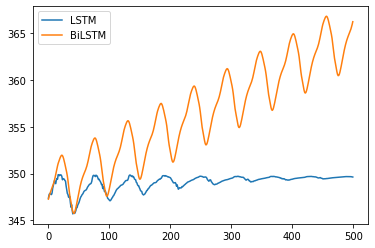

In [289]:
plt.plot(preds_lstm, label='LSTM')
plt.plot(preds_bilstm, label='BiLSTM')
plt.legend()